In [1]:
import sympy as sp 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import thesis_rcparams
import tstrippy
from astropy import units as u
from astropy import constants as const
import martos_tidal_tensor as MTT
import multiprocessing as mp 

In [2]:
# halo params
halomass = 1e12 
haloradius = 30
gamma = 4.5
rcut = 400
# cluster params 
cluster_mass = 1e6
cluster_radius = 20/1000
NP = int(1000)
# orbit params 
r0 = 4*haloradius
eccen = 0.1
num_orbits = 4

In [3]:
# load in units 
unitL= u.kpc
unitV= u.km/u.s
unitT= unitL/unitV
unitM= u.Msun
unitG= unitL*unitV**2/unitM
G=const.G.to(unitG).value

# scale factors to halo 
r_scale = haloradius * unitL
m_scale = halomass*unitM
v_scale = np.sqrt(G*unitG*m_scale/r_scale)
t_scale = r_scale/v_scale
F_scale = G*unitG*m_scale/r_scale**2
F_tidal_scale = F_scale/r_scale * (cluster_radius*r_scale.unit/r_scale.value)  
vmin = 1e-4*F_tidal_scale.value
vmax = 1e-2*F_tidal_scale.value
cmap = mpl.cm.rainbow
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)

In [4]:
# parameters for the local tidal field 
dx = haloradius/5000
n_vectors = 25


In [5]:
# pack up sim params 
haloparams          =   G,halomass,haloradius,gamma,rcut
orbitparams         =   r0,eccen,num_orbits
isotropicplummer    =   G,cluster_mass,cluster_radius,NP

In [6]:
# do the simulation
timesteps,  hostorbit, freshstream=MTT.make_stream(haloparams,orbitparams, isotropicplummer)

Data size is 4.59 Gbyte bytes
Time taken to integrate the orbit:  0:01:48.187058


In [11]:
dtfactor = 10
# unscale the result 
orbit,stream= MTT.unscale(r_scale,v_scale, hostorbit,freshstream)
# get the position of the host
xt, yt, zt, vxt, vyt, vzt = orbit
xp, yp, zp, vxp, vyp, vzp = stream
pos = np.array([xt[-1],yt[-1],zt[-1]])
myellipse,circle=MTT.get_dimensionless_deformed_ellipse(pos*haloradius, dx/2,haloparams,dtfactor=dtfactor)
dXs, dYs, F_tides= MTT.get_tidal_vectors(pos,dx,gamma, n_vectors)
F_tides_mag = np.linalg.norm(F_tides,axis=0)

In [12]:
vmin = 1e-3*F_tidal_scale.value
vmax = 1e-1*F_tidal_scale.value
cmap = mpl.cm.rainbow
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cbarstuff = norm,cmap
F_colors = cmap(norm(F_tides_mag))
# pack up the stream and orbit
orbitxy = xt, yt
streamxy = xp, yp
tidal_stuff = dXs, dYs, F_tides
ellipseCirlcle = myellipse, circle


In [13]:
F_tides_mag = np.linalg.norm(F_tides,axis=0)
F_colors = cmap(norm(F_tides_mag))


/Users/sferrone/repos/phd-thesis-ferrone/demos/tidalTensor/martos_tidal_tensor.py:294: RuntimeWarning: invalid value encountered in divide
  axes[1].quiver(pos[0]+dXs, pos[1]+dYs, F_tides[0]/F_tides_mag, F_tides[1]/F_tides_mag,color=F_colors,scale=30, width=1/200,)


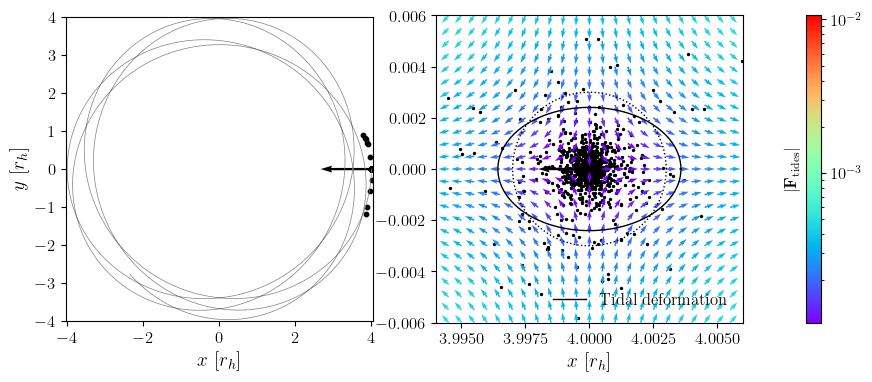

In [14]:
fig, axes = MTT.plot_martos_tidal_field(orbitxy, streamxy, tidal_stuff,
                            ellipseCirlcle, cbarstuff)


In [15]:
dtfrac=1/50
# get the particle distribution
xp,yp,zp,vxp,vyp,vzp = tstrippy.ergodic.isotropicplummer(*isotropicplummer)
rplum = tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(cluster_radius)
# COMPUTE THE TIME STEP 
rps= np.sqrt(xp**2+yp**2+zp**2)
vps= np.sqrt(vxp**2+vyp**2+vzp**2)
tps = rps/vps
chartime=np.median(tps)
dt = chartime*dtfrac

In [29]:
n_eccen = 30
eccentricities = np.logspace(-2, -.01,n_eccen)
norm = mpl.colors.LogNorm(vmin=1e-2, vmax=10**(-.01))
cmap = mpl.cm.rainbow

In [30]:
initial_time=0
haloname = "allensantillianhalo"
staticgalaxy = (haloname, haloparams)
# compute the host orbit, why is it too circular??
    # get the initial conditions ofr the host orbit 
xs,ys=[],[]
rstd = []
rs = []
Rs = []
thetas = []
for i in range(len(eccentricities)):
    eccen = eccentricities[i]
    x0=r0
    v_circ= MTT.compute_vcirc(haloparams,x0)
    x0,y0,z0  = x0,0.0,0.0
    vx0,vy0,vz0 = 0.0, (1-eccen) * v_circ, 0.0
    initialkinematics = (x0, y0, z0, vx0, vy0, vz0)

    # set the integration parameters
    integration_time = 2*np.pi*num_orbits*(x0/v_circ)
    NSTEP = int(integration_time/dt)
    integrationparameters = (float(initial_time), dt,NSTEP)

    ### CLUSTER ORBIT 
    tstrippy.integrator.deallocate()
    tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
    tstrippy.integrator.setintegrationparameters(*integrationparameters)
    tstrippy.integrator.setinitialkinematics(*initialkinematics)
    tstrippy.integrator.setbackwardorbit()
    xt,yt,zt,vxt,vyt,vzt = tstrippy.integrator.leapfrogintime(NSTEP,1)
    timesteps = tstrippy.integrator.timestamps.copy()
    # flip and change the sign of the velocities
    xt=xt[0,::-1]
    yt=yt[0,::-1]
    zt=zt[0,::-1]
    vxt=-vxt[0,::-1]
    vyt=-vyt[0,::-1]
    vzt=-vzt[0,::-1]
    timesteps=timesteps[::-1]
    tstrippy.integrator.deallocate()    
    theta = np.arctan2(yt,xt)
    # unwrap the angles
    theta = np.unwrap(theta)
    thetas.append(theta)
    xs.append(xt)
    ys.append(yt)
    Rs.append(np.sqrt(xt**2+yt**2))
    rs.append(np.sqrt(xt**2+yt**2+zt**2))
    rstd.append(np.std(np.sqrt(xt**2+yt**2+zt**2)))

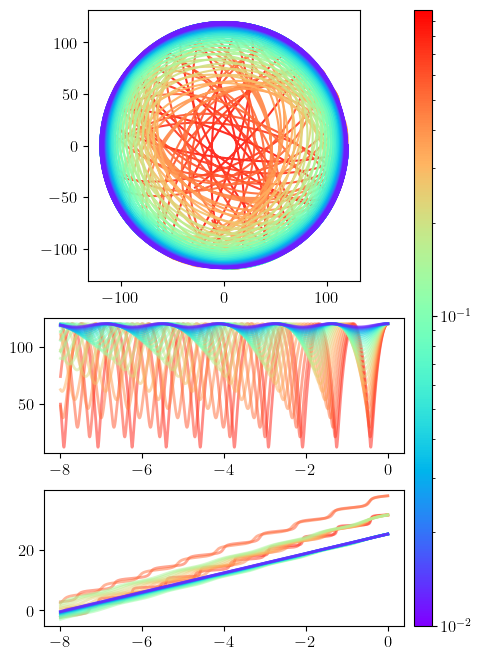

In [31]:
fig=plt.figure(figsize=(5,8))
gs = mpl.gridspec.GridSpec(3, 2, width_ratios=[1, 0.05], height_ratios=[2,1,1], wspace=0.05)
axis = fig.add_subplot(gs[0, 0])
caxis= fig.add_subplot(gs[:, 1])
axis2 = fig.add_subplot(gs[1, 0])
axis3 = fig.add_subplot(gs[2, 0])

n_eccen = len(eccentricities)
for i in range(1,n_eccen-1):
    # plot the orbit 
    color = cmap(norm(eccentricities[i]))
    axis.plot(xs[i],ys[i],
                color=color,
                lw=1.5,
                alpha=0.9,zorder=n_eccen-i)
    # plot the host orbit
    axis2.plot(timesteps,rs[i], color=color, alpha=0.5,zorder=n_vectors-i)
    axis3.plot(timesteps,thetas[i], color=color, alpha=0.5,zorder=n_eccen-i)
    
axis.set_aspect('equal')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
caxis.set_yticks(eccentricities);
cbar=plt.colorbar(sm, cax=caxis, orientation='vertical')

## Make the plots to include in the thesis 

In [32]:
# make sure we get the correct color bar again 
# scale factors to halo 
r_scale = haloradius * unitL
m_scale = halomass*unitM
v_scale = np.sqrt(G*unitG*m_scale/r_scale)
t_scale = r_scale/v_scale
F_scale = G*unitG*m_scale/r_scale**2
F_tidal_scale = F_scale/r_scale * (cluster_radius*r_scale.unit/r_scale.value)  
vmin = 1e-4*F_tidal_scale.value
vmax = 5e-1*F_tidal_scale.value
cmap = mpl.cm.rainbow
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)

# pick the parameters to iterate over 
eccentricities = [0.1]
gammas = [2.02,4.5]
r0s = np.array([0.25,4])*haloradius
num_orbits = [10,5]
# make the arguments 
args = []
totalargs = len(eccentricities)*len(gammas)*len(r0s)
print("Total number of args: {}".format(totalargs))
for eccen in eccentricities:
    for gamma in gammas:
        for r0, num_orbit in zip(r0s,num_orbits):
            haloparams = G,halomass,haloradius,gamma,rcut
            args.append((haloparams, isotropicplummer, (r0,eccen,num_orbit), norm, cmap, dx, r_scale, v_scale, n_vectors))


ncpu=mp.cpu_count()-2
pool = mp.Pool(ncpu)
print("Number of processes: {}".format(ncpu))
for i, arg in enumerate(args):
    print("Processing {}/{}".format(i+1, totalargs))
    pool.apply_async(MTT.compute_and_make_plot, args=arg)
# MTT.compute_and_make_plot(*args[0])
pool.close()
pool.join()

Total number of args: 4
Number of processes: 6
Processing 1/4
Processing 2/4
Processing 3/4
Processing 4/4
Data size is 1.76 Gbyte bytes
Data size is 5.76 Gbyte bytes
Data size is 8.70 Gbyte bytes
Data size is 7.31 Gbyte bytes
Time taken to integrate the orbit:  0:00:44.106685


/Users/sferrone/repos/phd-thesis-ferrone/demos/tidalTensor/martos_tidal_tensor.py:294: RuntimeWarning: invalid value encountered in divide
  axes[1].quiver(pos[0]+dXs, pos[1]+dYs, F_tides[0]/F_tides_mag, F_tides[1]/F_tides_mag,color=F_colors,scale=30, width=1/200,)
/Users/sferrone/repos/phd-thesis-ferrone/demos/tidalTensor/martos_tidal_tensor.py:352: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved figure to ../../images/martos_tidal_field_202_10_25.png
Time taken to integrate the orbit:  0:02:40.911466


/Users/sferrone/repos/phd-thesis-ferrone/demos/tidalTensor/martos_tidal_tensor.py:294: RuntimeWarning: invalid value encountered in divide
  axes[1].quiver(pos[0]+dXs, pos[1]+dYs, F_tides[0]/F_tides_mag, F_tides[1]/F_tides_mag,color=F_colors,scale=30, width=1/200,)
/Users/sferrone/repos/phd-thesis-ferrone/demos/tidalTensor/martos_tidal_tensor.py:352: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved figure to ../../images/martos_tidal_field_450_10_400.png
Time taken to integrate the orbit:  0:03:33.329148


/Users/sferrone/repos/phd-thesis-ferrone/demos/tidalTensor/martos_tidal_tensor.py:294: RuntimeWarning: invalid value encountered in divide
  axes[1].quiver(pos[0]+dXs, pos[1]+dYs, F_tides[0]/F_tides_mag, F_tides[1]/F_tides_mag,color=F_colors,scale=30, width=1/200,)
/Users/sferrone/repos/phd-thesis-ferrone/demos/tidalTensor/martos_tidal_tensor.py:352: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved figure to ../../images/martos_tidal_field_202_10_400.png
Time taken to integrate the orbit:  0:04:22.976417


/Users/sferrone/repos/phd-thesis-ferrone/demos/tidalTensor/martos_tidal_tensor.py:294: RuntimeWarning: invalid value encountered in divide
  axes[1].quiver(pos[0]+dXs, pos[1]+dYs, F_tides[0]/F_tides_mag, F_tides[1]/F_tides_mag,color=F_colors,scale=30, width=1/200,)
/Users/sferrone/repos/phd-thesis-ferrone/demos/tidalTensor/martos_tidal_tensor.py:352: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved figure to ../../images/martos_tidal_field_450_10_25.png


In [33]:
def plot_martos_tidal_field(orbitxy,streamxy,tidal_stuff,ellipseCirlcle, cbarstuff,
                       AXES1 = {"xlabel": r"$x$ [$r_h$]","ylabel": r"$y$ [$r_h$]","aspect": "equal",},
                       AXES2 = {"xlabel": r"$x$ [$r_h$]","aspect": "equal",}):
    # unpack the inputs
    xt_, yt_ = orbitxy
    dXs, dYs, F_tides,F_tides_mag,F_colors = tidal_stuff
    xp,yp= streamxy
    myellipse, circle = ellipseCirlcle
    norm,cmap= cbarstuff

    pos = np.array([xt_[-1],yt_[-1]])
    # add the limits to the AXES2
    AXES2["xlim"] = [pos[0]+dXs.min(), pos[0]+dXs.max()]
    AXES2["ylim"] = [pos[1]+dYs.min(), pos[1]+dYs.max()]
    # set the limits to the AXES1
    dw = .01
    AXES1["xlim"] = [(1+dw)*xt_.min(), (1+dw)*xt_.max()]
    AXES1["ylim"] = [(1+dw)*yt_.min(), (1+dw)*yt_.max()]

    # set up figure 
    fig=plt.figure(figsize=(11.75-2,5))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.30)
    axes = [ ]
    axes.append(fig.add_subplot(gs[0, 0]))
    axes.append(fig.add_subplot(gs[0, 1]))
    caxis=fig.add_subplot(gs[0, 2])

    axes[0].plot(xt_, yt_, color='gray', lw=0.5,)
    axes[0].scatter(xp,yp, color='black', s=1, )
    axes[0].quiver(pos[0], pos[1], -pos[0], -pos[1], color='black', scale=8)


    axes[1].scatter(xp,yp, color='gray', s=1, zorder=0)
    axes[1].plot(pos[0]+myellipse[0], pos[1]+myellipse[1], color='black', lw=1, label='Tidal deformation')
    axes[1].plot(pos[0]+circle[0], pos[1]+circle[1], color='k', lw=1, linestyle=":")
    axes[1].quiver(pos[0]+dXs, pos[1]+dYs, F_tides[0]/F_tides_mag, F_tides[1]/F_tides_mag,color=F_colors,scale=30, width=1/200,)
    axes[1].quiver(pos[0], pos[1], -pos[0], -pos[1], color='black', scale=4, )

    axes[0].set(**AXES1)
    axes[1].set(**AXES2)
    axes[1].legend(frameon=False)

    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=caxis)
    cbar.set_label(r"$\left| \mathbf{F}_{\mathrm{tides}} \right|$", fontsize=12)
    caxis.tick_params(labelsize=12)
    caxis.yaxis.set_label_position("left")

    # Make the colorbar the same height as axes[1]
    pos_ax1 = axes[1].get_position()
    pos_cax = caxis.get_position()
    caxis.set_position([pos_cax.x0, pos_ax1.y0, pos_cax.width, pos_ax1.height])
    return fig, axes

In [34]:
def get_tidal_vectors(pos,dx,gamma, n_vectors=25):
    dxs,dys = np.linspace(-dx,dx,n_vectors), np.linspace(-dx,dx,n_vectors)
    dXs, dYs = np.meshgrid(dxs,dys)
    dXs,dYs  = dXs.flatten(), dYs.flatten()
    dZs = np.zeros_like(dXs)
    tidal_tensor = MTT.normalized_martos_tidal_tensor(pos,gamma)
    F_tides = tidal_tensor @ np.array([dXs,dYs,dZs])
    return dXs, dYs, F_tides

In [35]:
def unscale(r_scale,v_scale, hostorbit,stream):
    # unpack the orbit
    xt,yt,zt,vx,vy,vz=hostorbit
    xpt,ypt,zpt,vxpt,vypt,vzpt=stream
    # scale everything 
    xt_= xt/r_scale.value
    yt_= yt/r_scale.value
    zt_= zt/r_scale.value
    
    xt_= xt/r_scale.value
    yt_= yt/r_scale.value
    zt_= zt/r_scale.value
    vxt_= vx/v_scale.value
    vyt_= vy/v_scale.value
    vzt_= vz/v_scale.value
    # unscale everything 
    xpt_ = xpt/r_scale.value
    ypt_ = ypt/r_scale.value
    zpt_ = zpt/r_scale.value
    vxpt_ = vxpt/v_scale.value
    vypt_ = vypt/v_scale.value
    vzpt_ = vzpt/v_scale.value
    
    orbit = xt_, yt_, zt_, vxt_, vyt_, vzt_
    stream = xpt_, ypt_, zpt_, vxpt_, vypt_, vzpt_
    return orbit, stream

In [36]:
def compute_and_make_plot(haloparams, isotropicplummer, orbitparams, norm, cmap, dx, r_scale, v_scale, n_vectors=25):
    # unpack the params
    G,halomass,haloradius,gamma,rcut = haloparams
    G,cluster_mass,cluster_radius,NP = isotropicplummer
    r0,eccen,num_orbits = orbitparams


    figtitle = r"$\gamma, e$ = ({:.02f},{:.02f})".format(gamma,eccen)
    fname = "../../images/martos_tidal_field_{:d}_{:d}_{:d}.png".format(int(gamma),int(eccen*100),int(100*r0/r_scale.value))

    # do the simulation
    timesteps,  hostorbit, freshstream=MTT.make_stream(haloparams,orbitparams, isotropicplummer)
    # unscale the result 
    orbit,stream= unscale(r_scale,v_scale, hostorbit,freshstream)
    # get the position of the host
    xt, yt, zt, vxt, vyt, vzt = orbit
    xpt, ypt, zpt, vxpt, vypt, vzpt = stream
    pos = np.array([xt[-1],yt[-1],zt[-1]])
    myellipse,circle=MTT.get_dimensionless_deformed_ellipse(pos, dx/2,haloparams)
    dXs, dYs, F_tides= get_tidal_vectors(pos,dx,gamma, n_vectors)
    F_tides_mag = np.linalg.norm(F_tides,axis=0)
    F_colors = cmap(norm(F_tides_mag))

    # pack up the stream and orbit
    orbitxy = xt, yt
    streamxy = xpt[:,-1], ypt[:,-1]
    tidal_stuff = dXs, dYs, F_tides,F_tides_mag,F_colors
    ellipseCirlcle = myellipse, circle
    cbarstuff = norm,cmap
    # make the fig 
    fig, axes = martos_tidal_field(orbitxy, streamxy, tidal_stuff,
                                ellipseCirlcle, cbarstuff)
    axes[0].set_title(figtitle, fontsize="large", y=1)
    fig.tight_layout()
    fig.savefig(fname, dpi=300, bbox_inches='tight')
    print("Saved figure to {}".format(fname))
    plt.close(fig)
    return None

In [ ]:
# halo params
halomass = 1e12 
haloradius = 30
gamma = 2.02
rcut = 100
# cluster params 
cluster_mass = 1e6
cluster_radius = 20/1000
NP = int(1000)
# orbit params 
r0 = 60
eccen = 0.5
num_orbits = 3

# plot params 
# make the color map 
vmin = 1e-5
vmax = 1e-2
# parameters for the local tidal field 
dx = haloradius/5000
n_vectors = 25
cmap = mpl.cm.rainbow
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)

In [ ]:
# load in units 
unitL= u.kpc
unitV= u.km/u.s
unitT= unitL/unitV
unitM= u.Msun
unitG= unitL*unitV**2/unitM
G=const.G.to(unitG).value

# scale factors to halo 
r_scale = haloradius * unitL
m_scale = halomass*unitM
v_scale = np.sqrt(G*unitG*m_scale/r_scale)
t_scale = r_scale/v_scale

In [ ]:
# pack up sim params 
haloparams          =   G,halomass,haloradius,gamma,rcut
isotropicplummer    =   G,cluster_mass,cluster_radius,NP
orbitparams         =   r0,eccen,num_orbits

In [ ]:
# pick the parameters to iterate over 
eccentricities = [0.1,0.3,0.5]
gammas = [1.5,2.02,3,4.5]
r0s = np.array([0.25,1,4])
num_orbits = [10,8,5]
# make the arguments 
args = []
totalargs = len(eccentricities)*len(gammas)*len(r0s)
print("Total number of args: {}".format(totalargs))
for eccen in eccentricities:
    for gamma in gammas:
        for r0, num_orbit in zip(r0s,num_orbits):
            args.append((haloparams, isotropicplummer, (r0,eccen,num_orbit), norm, cmap, dx, r_scale, v_scale, n_vectors))


pool = mp.Pool(processes=mp.cpu_count())
print("Number of processes: {}".format(mp.cpu_count()))
pool.starmap(compute_and_make_plot, args)
pool.close()
pool.join()

In [ ]:
compute_and_make_plot(haloparams, isotropicplummer, orbitparams, norm, cmap, dx, r_scale, v_scale, n_vectors=25)

In [ ]:
# do the simulation
timesteps,  hostorbit, freshstream=MTT.make_stream(haloparams,orbitparams, isotropicplummer)

In [ ]:
# unscale the result 
orbit,stream= unscale(r_scale,v_scale, hostorbit,freshstream)
# get the position of the host
xt, yt, zt, vxt, vyt, vzt = orbit
xpt, ypt, zpt, vxpt, vypt, vzpt = stream
pos = np.array([xt[-1],yt[-1],zt[-1]])


In [ ]:
myellipse,circle=MTT.get_dimensionless_deformed_ellipse(pos, dx/2,haloparams)
dXs, dYs, F_tides= get_tidal_vectors(pos,dx,gamma, n_vectors)
F_tides_mag = np.linalg.norm(F_tides,axis=0)
F_colors = cmap(norm(F_tides_mag))

In [ ]:
# pack up the stream and orbit
orbitxy = xt, yt
streamxy = xpt[:,-1], ypt[:,-1]
tidal_stuff = dXs, dYs, F_tides,F_tides_mag,F_colors
ellipseCirlcle = myellipse, circle
cbarstuff = norm,cmap
# make the fig 
fig, axes = martos_tidal_field(orbitxy, streamxy, tidal_stuff,
                               ellipseCirlcle, cbarstuff)
axes[0].set_title(figtitle, fontsize="large", y=1)
fig.tight_layout()
fig.savefig(fname, dpi=300, bbox_inches='tight')

## Martos Halo Tidal Tensor: 

This was a fun exercise. Take the Martos halo:

$$ M_\text{enc}(r) = M_0\frac{(r/r_s)^\gamma}{1+(r/r_s)^{\gamma-1}}$$ 

which can be dedimensionalized by the following subs: $s=r/r_s$ and $M'=M/M_0$

$$ M'_\text{enc}(s) =\frac{s^\gamma}{1+s^{\gamma-1}}$$ 

Which is already de-dimensionalized. I can compute the force at any point by taking advantage of spherical symmetry:

$$ F = -\frac{GM_\text{enc}(r)}{r^3}\vec{r}$$

I want to de-dimensionalize this force given that $s=r/r_s$ where $r_s$ is the halo's characteristic length. It follows that $s^2 = x'^2+y'^2+z'^2$. I can now rewrite the dedimensionalized force as: 

$$ F' =-\frac{M'_\text{enc}(s)}{s^3}\vec{s}$$

And it is related to the full force as: $ F=F'F_0$ where

$$F_0 = \frac{GM_0}{r_s^2}$$

and now, we want to find the tidal field. So I can take the jacobian of the transform: 

$$ F_\text{tidal} = \text{J}(F)d\vec{r} $$

And the Jacobian of the transform is given by taken all the derivatives with respect to each component. 

$$
\text{J}(F)= \left(\begin{matrix}
\partial_x F_x & \partial_y F_x & \partial_z F_x \\
\partial_x F_y & \partial_y F_y & \partial_z F_y \\
\partial_x F_z & \partial_y F_z & \partial_z F_z 
\end{matrix}\right)
$$

Given the symmetry of the problem, I can just compute the cross term as well as the parallel term, which will then generalize. 

I solved this in a notebook and here is the result: 

$$
\text{J}(F')=-\frac{M'_\text{enc}(s)}{s^3}\left(\begin{matrix}
1-x'^2s^{-2}f(s) & -x'y's^{-2}f(s) & -x'z's^{-2}f(s)  \\
\dots & 1-y'^2s^{-2}f(s) & -y'z's^{-2}f(s) \\
\dots  & \dots  & 1-z'^2s^{-2}f(s)
\end{matrix}\right)
$$

Where 
$$ f(s) = 2 - \frac{\gamma-1}{1+s^{\gamma-1}}

In [ ]:
def f(s,gamma):
    numerator = gamma -1 
    denominator = 1 + s**(gamma-1)
    return 2 - numerator/denominator

def mass_profile(s,gamma):
    numerator = s**gamma
    denominator = 1 + s**(gamma-1)
    return numerator/denominator


In [ ]:
s = np.logspace(-3, 2, 100)
gammas = np.arange(1., 5,0.25)
solutions = []
mass_profiles = []
for gamma in gammas:
    f_s = f(s, gamma)
    solutions.append(f_s)
    mass_profile_s = mass_profile(s, gamma)
    mass_profiles.append(mass_profile_s)

In [ ]:


cmap = mpl.cm.get_cmap('jet', len(gammas))
norm=mpl.colors.Normalize(vmin=min(gammas), vmax=max(gammas))

fig=plt.figure(figsize=(8, 6))
gs=fig.add_gridspec(2, 2, width_ratios=[1, 0.05])
axes=[]
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[1, 0]))
cax=fig.add_subplot(gs[:, 1])
for i, gamma in enumerate(gammas):
    color = cmap(i)
    axes[0].plot(s, solutions[i], label=f'gamma={gamma:.2f}', color=color)
sm=plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=fig.colorbar(sm, cax=cax)
cbar.set_label('gamma', rotation=270, labelpad=15)
axes[0].vlines(1, -2, 2.1, color='black', lw=0.5)
axes[0].hlines(0, 0, 5, color='black', lw=0.5)
axes[0].set_xlim(0, 5)
axes[0].set_ylim(-2, 2.1)
axes[0].set_ylabel('f(s)')
for i, gamma in enumerate(gammas):
    color = cmap(i)
    axes[1].plot(s, mass_profiles[i], label=f'gamma={gamma:.2f}', color=color)
axes[1].vlines(1, 0, 5, color='black', lw=0.5)
axes[1].set_yscale('log')
axes[1].set_ylim(1e-9, 1e3)
axes[0].set_xlim(np.min(s), np.max(s))
axes[1].set_xlim(np.min(s), np.max(s))
axes[0].set_xscale('log')
axes[1].set_xscale('log')

axes[1].set_xlabel('s')
axes[0].set_title('f(s) controls the sign of the tidal tensor')
axes[1].set_ylabel('Mass profile')
fig.tight_layout()

An interesting note. 

$\gamma=3$ is a critical value for the value. If it is greater than 3, when are beneath the characteristic radius of the value, each shell 

## Integrate some streams in this potential 

In [ ]:
def get_single_orbit(staticgalaxy, initial_conditions, integration_params):
    """
    Run a single orbit with the given static galaxy and initial conditions.
    """
    Nparticle = 1 
    # Set up the integrator

    tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
    tstrippy.integrator.setintegrationparameters(*integration_params)
    tstrippy.integrator.setinitialkinematics(*initial_conditions)

    # Integrate the orbit
    Nstep = integration_params[2]
    xt,yt,zt,vxt,vyt,vzt=tstrippy.integrator.leapfrogintime(Nstep,Nparticle)
    tstrippy.integrator.deallocate()
    return xt[0], yt[0], zt[0], vxt[0], vyt[0], vzt[0]

In [ ]:
def compute_vcirc(haloparams, x0):
    G,Mo,rc,gamma,rcut = haloparams
    # get the initial veloicity
    Mr=mass_profile(x0/rc, gamma) * Mo 
    # compute the circular velocity
    v_circ = np.sqrt(G * Mr / x0) 
    return v_circ


In [ ]:
def get_xy_plane_initial_conditions(haloparams, x0, eccen):
    """
    Get the initial conditions for the orbit.
    """
    G,Mo,rc,gamma,rcut = haloparams
    # Set up the initial conditions
    x0 = x0 
    y0 = 0.0 
    z0 = 0.0 
    # get the initial veloicity
    v_circ= compute_vcirc(haloparams, x0)
    # pick the velocities 
    vx0 = 0.0 
    vy0 = (1-eccen) * v_circ
    vz0 = 0.0 
    return x0, y0, z0, vx0, vy0, vz0

In [ ]:
def get_integration_params(haloparams,x0,initial_time=0,num_orbits=10,divisor=1000):
    """
    Get the integration parameters for the orbit.
    """
    # get the initial veloicity
    v_circ= compute_vcirc(haloparams,x0)
    # set the time characterstic
    tchar = x0/v_circ
    # set the time step
    dt = tchar/divisor
    # set the integration time
    integration_time = np.pi*num_orbits*tchar
    Nstep = int(integration_time/dt)
    return (float(initial_time), dt,Nstep)


In [ ]:
unitL = u.kpc
unitV = u.km/u.s
unitT = unitL/unitV
unitM = u.Msun
unitG = unitL*unitV**2/unitM
G=const.G.to(unitG).value

In [ ]:
haloname = "allensantillianhalo"
halomass = 1e12
haloradius = float(30)
gamma = 2.02
rcut = float(100)
haloparams = [float(G),halomass,haloradius,gamma,rcut]

In [ ]:
# pick the initial orbit 
x0=float(1)
eccen = 0.6
num_orbits = 10
initial_time = 0.0
gamma = 2.02

In [ ]:
vcirc= compute_vcirc(haloparams,x0)

In [ ]:
x0=3
num_orbits=100
orbiis = []
nsolutions = 5
eccentricities = np.linspace(0, 0.8, nsolutions)
cmap = mpl.colormaps.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, nsolutions)]
for i in range(nsolutions):
    eccen = eccentricities[i]
    staticgalaxy = (haloname, haloparams)
    initial_conditions = get_xy_plane_initial_conditions(haloparams, x0, eccen)
    integration_params = get_integration_params(haloparams,x0,initial_time,num_orbits)
    xt,yt,zt,vxt,vyt,vzt = get_single_orbit(staticgalaxy, initial_conditions, integration_params)
    orbiis.append((xt,yt,zt,vxt,vyt,vzt))

In [ ]:
AXIS={"aspect":"equal", "adjustable":"box"}
sm = plt.cm.ScalarMappable(cmap=cmap)

In [ ]:
fig,axis=plt.subplots(figsize=(8, 6))
for i in range(nsolutions):
    xt,yt,zt,vxt,vyt,vzt = orbiis[i]
    color = colors[i]
    axis.plot(xt, yt, color=color, lw=1,alpha=0.5)
axis.set(**AXIS)
cbar=fig.colorbar(sm, ax=axis)
cbar.set_label('eccentricity', rotation=270, labelpad=15)

# $\gamma$

In [ ]:
# now do a range of gamma
gammas = np.arange(0, 5.0+1, 1.5)
x0=1
num_orbits=100
eccen = 0.8
nsolutions = len(gammas)
orbiis = []
cmap = mpl.colormaps.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, nsolutions)]
for i in range(nsolutions):
    gamma = gammas[i]
    haloparams = [float(G),halomass,haloradius,gamma,rcut]
    staticgalaxy = (haloname, haloparams)
    initial_conditions = get_xy_plane_initial_conditions(haloparams, x0, eccen)
    integration_params = get_integration_params(haloparams,x0,initial_time,num_orbits)
    xt,yt,zt,vxt,vyt,vzt = get_single_orbit(staticgalaxy, initial_conditions, integration_params)
    orbiis.append((xt,yt,zt,vxt,vyt,vzt))

In [ ]:
norm = mpl.colors.Normalize(vmin=min(gammas), vmax=max(gammas))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
AXIS={"aspect":"equal", "adjustable":"box","xlabel":"x", "ylabel":"y"}

fig,axis=plt.subplots(figsize=(8, 6))
for i in range(nsolutions):
    xt,yt,zt,vxt,vyt,vzt = orbiis[i]
    color = colors[i]
    axis.plot(xt, yt, color=color, lw=1,alpha=0.5)
axis.set(**AXIS)
cbar=fig.colorbar(sm, ax=axis)
cbar.set_label(r'$\gamma$', rotation=270, labelpad=15)
fig.tight_layout()
axis.text(0.05, 0.95, r'$\textrm{{e}}$ = {:.02f}'.format(eccen), ha='left', va='center', fontsize=12, transform=axis.transAxes)

# Study the tidal field 

In [ ]:
def normalized_martos_tidal_tensor(r,gamma):
    """
    r is the position vector of the satellite with respect to the system
    dr is the position vector with respect to the center of mass of the satellite
    gamma is the mass envelope index
    """
    # Define the variables
    # assert isinstance(r,np.array), "a numpy array is expected"
    # assert isinstance(gamma, (int, float)), "a float or int is expected"
    # assert r.shape[0] == 3, "r must be a 3D vector"
    
    # get the norm of r and dr
    r_norm = np.linalg.norm(r)

    mass_enclosed = mass_profile(r_norm, gamma)
    f_s = f(r_norm, gamma)
    # make  the tensor
    tensor = np.zeros((3,3))
    # the diagonal elements
    tensor[0,0] = 1 -  f_s*(r[0]/r_norm)**2
    tensor[1,1] = 1 -  f_s*(r[1]/r_norm)**2
    tensor[2,2] = 1 -  f_s*(r[2]/r_norm)**2
    # the off diagonal elements
    tensor[0,1] = -f_s*(r[0]*r[1])/r_norm**2
    tensor[0,2] = -f_s*(r[0]*r[2])/r_norm**2
    tensor[1,0] = -f_s*(r[1]*r[0])/r_norm**2
    tensor[1,2] = -f_s*(r[1]*r[2])/r_norm**2
    tensor[2,0] = -f_s*(r[2]*r[0])/r_norm**2
    tensor[2,1] = -f_s*(r[2]*r[1])/r_norm**2
    # multiply by the mass enclosed
    tensor *= -(mass_enclosed/r_norm**3)
    return tensor

def get_dimensionless_deformed_ellipse(r0,dr,gamma,dtfactor=500):
    """
    starting with a circle deform it by the tidal tensor
    The deformation is (1/2)*T_magn*dt^2
    dt is dynamicaltime/dtfactor, if you wanna scale the deformation, mess with dtfactor
    dr is the radius of the circle
    """

    # get the deformation tensor
    tensor = normalized_martos_tidal_tensor(r0, gamma)
    # get the circle
    theta = np.linspace(0, 2*np.pi, 100)
    x = dr*np.cos(theta)
    y = dr*np.sin(theta)
    z = np.zeros_like(x)
    xyz = np.vstack((x,y,z))
    # get the tidal force at each point
    dF_circ = np.dot(tensor, xyz)
    circle = np.zeros((3, len(theta)))
    circle[0] =  x
    circle[1] =  y
    circle[2] =  z
    # get the characteristic time to scale the force into distance 
    r0_mag = np.linalg.norm(r0)
    vcirc=compute_vcirc([1,1,1,gamma,100,],r0_mag)
    t_orbit = 2*np.pi*r0_mag/vcirc
    dtstep = t_orbit/dtfactor
    myellipse =np.zeros((3, len(theta)))
    myellipse[0] = x+np.sign(dF_circ[0])* (1/2)*np.sqrt(np.abs(dF_circ[0]*dtstep**2))
    myellipse[1] = y+np.sign(dF_circ[1])* (1/2)*np.sqrt(np.abs(dF_circ[1]*dtstep**2))
    myellipse[2] = z+np.sign(dF_circ[2])* (1/2)*np.sqrt(np.abs(dF_circ[2]*dtstep**2))
    return myellipse,circle


In [ ]:
# unscaled 
gamma = 1.2
dx_width = 1/100
r0 = np.array([1/10,1/20,0])
tensor = normalized_martos_tidal_tensor(r0, gamma)
# diagonalize the tensor
eigenvalues, eigenvectors = np.linalg.eig(tensor)
scaleDown = (1)*dx_width
# normalize the eigen value such that the largest is 1
print(eigenvalues)
eigenvalues = eigenvalues/np.max(np.abs(eigenvalues))
print(eigenvalues)
# make the ellipse patch 
xy = np.array([r0[0], r0[1]])
width  = scaleDown*np.abs(eigenvalues[0])
height = scaleDown*np.abs(eigenvalues[1])
angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
tensor

In [ ]:
# make the vector field 
npoints = 15
dr = 1/100
dxs = np.linspace(-dr, dr, npoints)
dys = np.linspace(-dr, dr, npoints)
dX, dY = np.meshgrid(dxs, dys)
# get the vectors at each position 
dX = dX.flatten()
dY = dY.flatten()
dZ = np.zeros_like(dX)
pos = np.array([dX, dY, dZ])
dF = np.dot(tensor, pos)
# get the deformed ellipse
myellipse,circle = get_dimensionless_deformed_ellipse(r0, dr/5, gamma)
# translate the ellipse
myellipse[0] += r0[0]
myellipse[1] += r0[1]
myellipse[2] += r0[2]
# translate the circle
circle[0] += r0[0]
circle[1] += r0[1]
circle[2] += r0[2]
# get the colors for the ellipse
# get the colors for the unit vectors 
F_norm = np.linalg.norm(dF, axis=0)
f_cbar_norm = mpl.colors.Normalize(vmin=F_norm.min(), vmax=F_norm.max())
cmap = mpl.cm.get_cmap('rainbow')
F_colors= cmap(f_cbar_norm(F_norm))

In [ ]:
fig, axis = plt.subplots(figsize=(8, 6))
ellipse = mpl.patches.Ellipse(xy, width, height,angle=angle, facecolor='none', edgecolor="k", linewidth=2,)
# plot the vectors
axis.quiver(r0[0]+dX, r0[1]+dY, dF[0]/F_norm, dF[1]/F_norm,color=F_colors, alpha=0.5)
axis.scatter(r0[0], r0[1], color='red', s=100, label='Satellite')
# axis.add_patch(ellipse)
axis.plot(myellipse[0], myellipse[1], color='black', lw=1, label='Deformed ellipse')
normPos = np.linalg.norm(r0)
# plot the circle
axis.plot(circle[0], circle[1], color='k', lw=1, linestyle=":" )
axis.quiver(r0[0],r0[1],-r0[0]/normPos,-r0[1]/normPos, color='black', scale=10)
axis.set_aspect('equal')
axis.set_xlabel('x')
axis.set_ylabel('y')

# Make a stream

In [ ]:
# get the time step based on the initial conditions for the cluster... 
dtfrac = 1/50
NP = 1000
Mhost = 1e6
halfmassradius = 20/1000
rplum=tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(halfmassradius)
isotropicplummer=[G,Mhost,halfmassradius,NP]
xp,yp,zp,vxp,vyp,vzp = tstrippy.ergodic.isotropicplummer(*isotropicplummer)

# ok... get the distributions of dynamical times 

# lets do the mean od the dynamical tiem 
rps= np.sqrt(xp**2+yp**2+zp**2)
vps= np.sqrt(vxp**2+vyp**2+vzp**2)
tps = rps/vps

chartime=np.median(tps)
dt = chartime*dtfrac
print((dt*unitT).to(u.yr))
bins = np.logspace(np.log10(np.min(tps)), -1, 100)
counts = np.histogram(tps, bins=bins)[0]
bin_centers = 0.5*(bins[1:]+bins[:-1])
fig, axis = plt.subplots(figsize=(8, 6))
axis.hist(bin_centers, bins=bins, weights=counts, color='blue', alpha=0.5)
axis.set_xscale('log')
axis.set_yscale('log')
axis.text(0.05, 0.95, r'$\tau_{{\textrm{{dyn}}}} = {:.2e}$'.format(chartime), ha='left', va='center', fontsize=12, transform=axis.transAxes) 
axis.text(0.05, 0.85, r'$dt = {:.2e}$'.format(dt), ha='left', va='center', fontsize=12, transform=axis.transAxes)
axis.text(0.05, 0.75, r'$N_{{\textrm{{part}}}} = {}$'.format(NP), ha='left', va='center', fontsize=12, transform=axis.transAxes)
axis.text(0.05, 0.65, r'$M_{{\textrm{{host}}}} = {:.2e}$'.format(Mhost), ha='left', va='center', fontsize=12, transform=axis.transAxes)

axis.vlines(chartime, 0, 1e5, color='red', lw=1, linestyle="--", label='Median Dynamical time')
axis.vlines(dt, 0, 1e5, color='black', lw=1, linestyle="--", label='Time step')
axis.set_xlim(dt/10, 1e-1)
axis.set_xlabel(r'$\tau_{\textrm{dyn}}$')
axis.set_ylabel('Counts')
axis.set_title('Distribution of dynamical times for the cluster')
axis.legend(frameon=False)     

In [ ]:
# set the halo parameters
haloname = "allensantillianhalo"
halomass = 1e12
haloradius = float(14)
gamma = 3.5
rcut = float(100)
haloparams = [float(G),halomass,haloradius,gamma,rcut]
staticgalaxy = (haloname, haloparams)
# set the initial conditions
x0 = 28
eccen = 0.5
num_orbits = 10
initial_time = 0.0
# set the initial conditions
v_circ= compute_vcirc(haloparams,x0)
x0,y0,z0  = x0,0.0,0.0
vx0,vy0,vz0 = 0.0, (1-eccen) * v_circ, 0.0
initialkinematics = (x0, y0, z0, vx0, vy0, vz0)
# set the integration parameters
integration_time = 2*np.pi*num_orbits*(x0/v_circ)
NSTEP = int(integration_time/dt)
integrationparameters = (float(initial_time), dt,NSTEP)
# estimate the size of the output data
datasize = NP*6*NSTEP*4  # 4 bytes per float
datasize = datasize*u.byte  # Convert to byte units
print(datasize.to(u.Mbyte))
print((integration_time*unitT).to(u.Gyr))


In [ ]:
tstrippy.integrator.deallocate()
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setintegrationparameters(*integrationparameters)
tstrippy.integrator.setinitialkinematics(*initialkinematics)
tstrippy.integrator.setbackwardorbit()
xt,yt,zt,vxt,vyt,vzt = tstrippy.integrator.leapfrogintime(NSTEP,1)
timesteps = tstrippy.integrator.timestamps.copy()
# flip and change the sign of the velocities
xt=xt[0,::-1]
yt=yt[0,::-1]
zt=zt[0,::-1]
vxt=-vxt[0,::-1]
vyt=-vyt[0,::-1]
vzt=-vzt[0,::-1]
timesteps=timesteps[::-1]
tstrippy.integrator.deallocate()

In [ ]:
import datetime

startime=datetime.datetime.now()
# set the particle initial conditions
initial_conditions=(xp+xt[0],yp+yt[0],zp+zt[0],vxp+vxt[0],vyp+vyt[0],vzp+vzt[0])
# set the integration parameters
integrationparameters = (timesteps[0],dt,NSTEP)
# set the host perturber 
inithostperturber=(timesteps,xt,yt,zt,vxt,vyt,vzt,Mhost,rplum)
# do the integration 
tstrippy.integrator.deallocate()
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setintegrationparameters(*integrationparameters)
tstrippy.integrator.setinitialkinematics(*initial_conditions)
tstrippy.integrator.inithostperturber(*inithostperturber)
xpt, ypt, zpt, vptx, vpty, vptz = tstrippy.integrator.leapfrogintime(NSTEP,NP)
tstrippy.integrator.deallocate()
endtime=datetime.datetime.now()
print("Time taken to integrate the orbit: ", endtime-startime)

In [ ]:
index=12
# evaluate the final state of the simulation
fig,axis=plt.subplots(figsize=(8, 6))
axis.plot(xt, yt, color='black', lw=1, label='Satellite')
axis.scatter(xpt[:,-1], ypt[:,-1], color='red', s=1, label='Satellite')
axis.set_aspect('equal')


In [ ]:
# check the energy of the host 
_,_,_,Phi = tstrippy.potentials.allensantillianhalo(haloparams,xt,yt,zt)
T = 0.5*(vxt**2 + vyt**2 + vzt**2)
E = T + Phi
# look at the diff from the initial energy
E0 = E[0]
E_diff = E-E0
E_RMS = np.abs(np.sqrt(E_diff**2)/E0)
fig,axis=plt.subplots(figsize=(8, 6))
axis.plot(E_RMS, color='black', lw=1, label='Satellite')
axis.set_yscale('log')
axis.set_xlabel('Time step')
axis.set_ylabel(r'$\Delta E/E_0$')

In [ ]:
# compute the energy conservation of all the star partickes 
NTIMESKIP = 100
E_RMS = np.zeros((NP,NSTEP//NTIMESKIP))
E0 = tstrippy.potentials.allensantillianhalo(haloparams,xpt[:,0],ypt[:,0],zpt[:,0])[3]
for i in range(0,NSTEP//NTIMESKIP):
    current_index = i*NTIMESKIP
    _,_,_,Phi = tstrippy.potentials.allensantillianhalo(haloparams,xpt[:,current_index],ypt[:,current_index],zpt[:,current_index])
    T = 0.5*(vptx[:,current_index]**2 + vpty[:,current_index]**2 + vptz[:,current_index]**2)
    E = T + Phi
    
    E_diff = E-E0
    E_RMS[:,i] = np.abs(np.sqrt(E_diff**2)/E0)


In [ ]:
fig,axis=plt.subplots(figsize=(8, 6))
for i in range(0,NP,100):
    axis.plot(timesteps[::NTIMESKIP][:-1],E_RMS[i], color='blue', lw=1, alpha=0.5);
axis.set_yscale('log')

In [ ]:
# what's the tidal field at this point?
dx=.25
r0 = np.array([xt[-1],yt[-1],zt[-1]])
dxs = np.linspace(-dx, dx, npoints)
dys = np.linspace(-dx, dx, npoints)
dX, dY = np.meshgrid(dxs, dys)
# get the vectors at each position
dX,dY = dX.flatten(),dY.flatten()
dZ=np.zeros_like(dX)
pos = np.array([dX, dY, dZ])
# get the tidal tensor
tensor = normalized_martos_tidal_tensor(r0/haloradius, gamma)
# get the tidal force at each point
dF = np.dot(tensor, pos)
# get the magnitude of the force
F_norm = np.linalg.norm(dF, axis=0)
# get the colors for the unit vectors
f_cbar_norm = mpl.colors.Normalize(vmin=F_norm.min(), vmax=F_norm.max())
cmap = mpl.cm.get_cmap('rainbow')
F_colors= cmap(f_cbar_norm(F_norm))
# get the deformed ellipse
myellipse,circle = get_dimensionless_deformed_ellipse(r0/haloradius, dx/(2*haloradius), gamma, dtfactor=100)

# rescale the ellipse
myellipse *= haloradius
# rescale the circle
circle *= haloradius
# translate the ellipse
myellipse[0] += r0[0]
myellipse[1] += r0[1]
myellipse[2] += r0[2]
# translate the circle
circle[0] += r0[0]
circle[1] += r0[1]
circle[2] += r0[2]

In [ ]:
# look at the last instance of the simulation
fig,axis=plt.subplots(figsize=(8, 6))
axis.plot(xt, yt, color='gray', lw=0.5,)
axis.scatter(xpt[:,-1], ypt[:,-1], color='black', s=1, )

axis.set_xlim(xt[-1]-dx, xt[-1]+dx)
axis.set_ylim(yt[-1]-dx, yt[-1]+dx)
# add the vectors
axis.quiver(r0[0]+dX, r0[1]+dY, dF[0]/F_norm, dF[1]/F_norm,color=F_colors, alpha=0.5)
# add the ellipse
axis.plot(myellipse[0], myellipse[1], color='black', lw=1, label='Deformed ellipse')
# add the circle
axis.plot(circle[0], circle[1], color='k', lw=1, linestyle=":" )
axis.set_aspect('equal')
# add the legend
axis.legend(frameon=False)

In [ ]:
unitL= u.kpc
unitV= u.km/u.s
unitT= unitL/unitV
unitM= u.Msun
unitG= unitL*unitV**2/unitM
G=const.G.to(unitG).value
haloparams          =   G,1e12,30,2.02,100
isotropicplummer    =   G,1e6,20/1000,1000
x0,eccen,num_orbits = 15,0.5,10
orbitparams=     haloparams,x0,eccen,num_orbits

timesteps,  hostorbit, stream=MTT.make_stream(haloparams,orbitparams, isotropicplummer,)

In [ ]:
timesteps,  hostorbit, stream=MTT.make_stream(haloparams,orbitparams, isotropicplummer,)